# Prophet Building for Multivariate with Roll and shift

In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(
    '~/Desktop/DATA_PROJECT/HSG_BA_and_DS_Applications/data/processed/final_df.csv',
    parse_dates=True,
    index_col=0
)

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)
df_copy = df.copy()

df_copy.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [2]:
# Example for one location
location = 'Little Collins St-Swanston St (East)'

# Prepare the data for Prophet (from the copied dataset)
data = df_copy[['Hour', location, 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h', 'clouds_all']].rename(
    columns={'Hour': 'ds', location: 'y'}
)

# Convert 'ds' to datetime format
data['ds'] = pd.to_datetime(data['ds'])

Processing Little Collins St-Swanston St (East)...


13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing


Metrics for Little Collins St-Swanston St (East): RMSE=151.55217699824877, MAPE=32.52057354894966, R²=0.9374251397615109


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


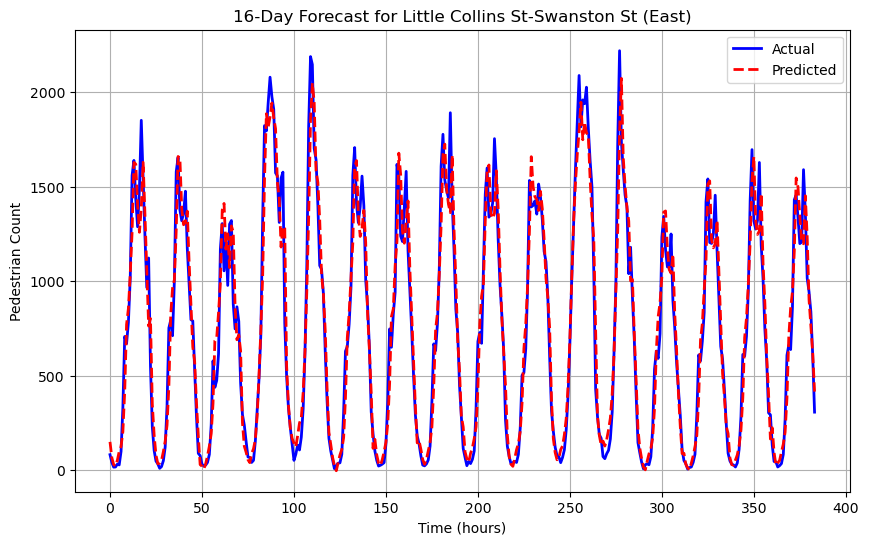

Processing Faraday St-Lygon St (West)...


13:38:07 - cmdstanpy - INFO - Chain [1] start processing
13:38:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for Faraday St-Lygon St (West): RMSE=40.42127040034719, MAPE=nan, R²=0.9528060753372349


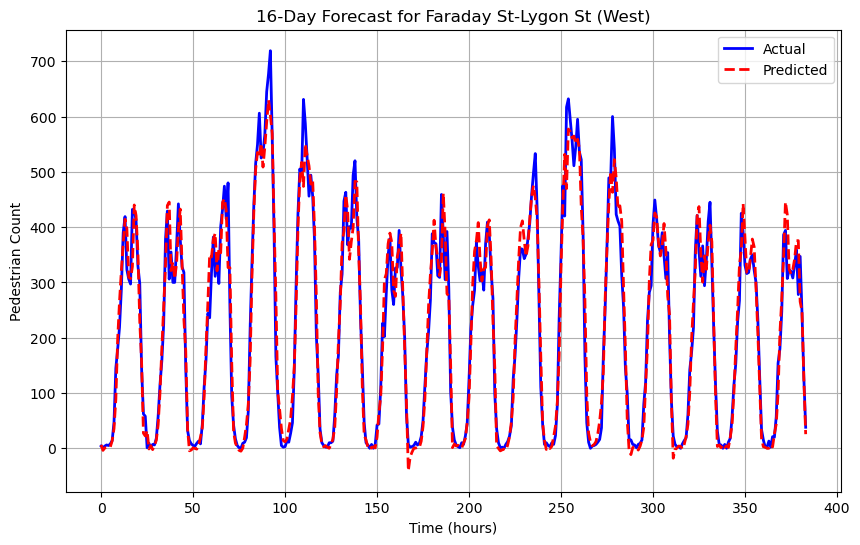

Processing Melbourne Central...


13:38:10 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing


Metrics for Melbourne Central: RMSE=180.29946847317137, MAPE=30.716877588457653, R²=0.9473807934635701


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


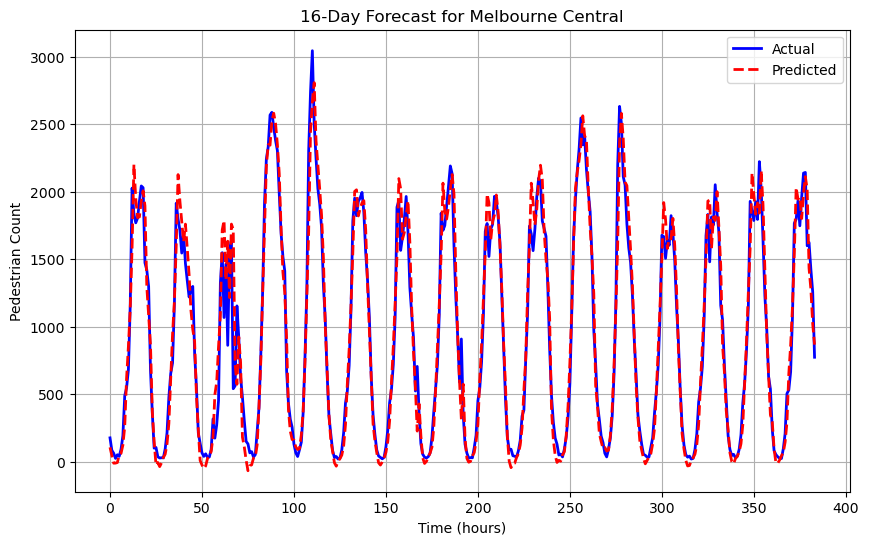

Processing Chinatown-Lt Bourke St (South)...


13:38:12 - cmdstanpy - INFO - Chain [1] start processing
13:38:14 - cmdstanpy - INFO - Chain [1] done processing


Metrics for Chinatown-Lt Bourke St (South): RMSE=87.93671946483974, MAPE=45.938631945679695, R²=0.9135677894458571


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


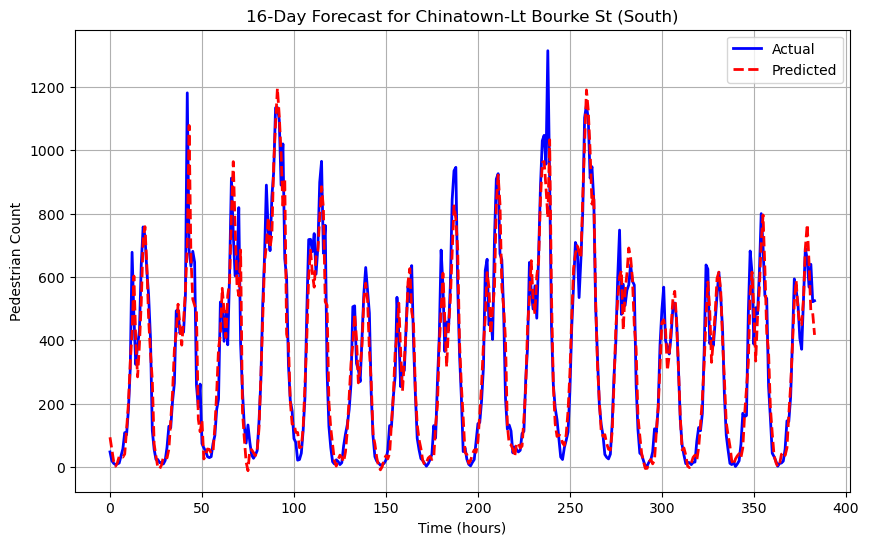

Processing Lonsdale St (South)...


13:38:15 - cmdstanpy - INFO - Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing


Metrics for Lonsdale St (South): RMSE=75.93946372199753, MAPE=20.069717435919678, R²=0.9270825294225353


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


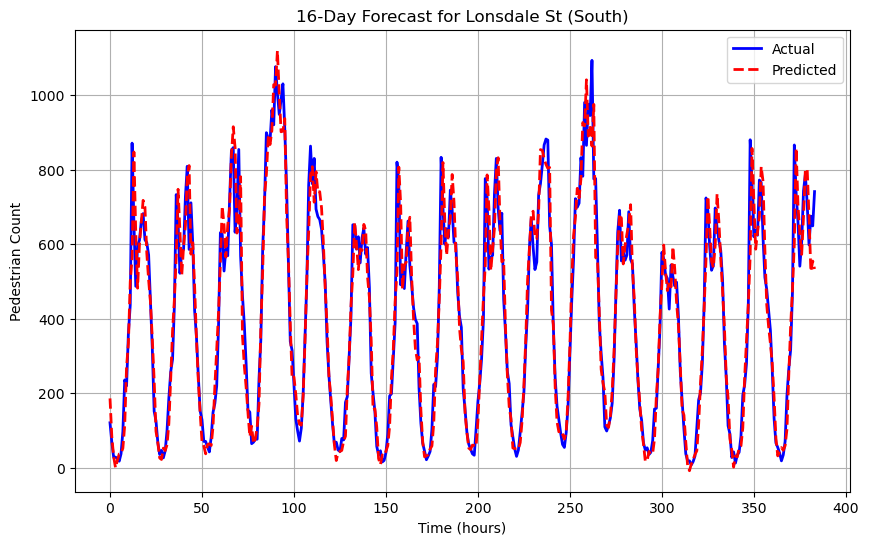

Results saved to 'prophet_with_lags_and_rolling_results.csv'
Model for Lonsdale St (South) saved as prophet_model_Lonsdale_St_(South).pkl


In [26]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    y_true_nonzero = np.where(y_true == 0, np.nan, y_true)  # Avoid divide-by-zero for MAPE
    mape = (np.abs((y_true - y_pred) / y_true_nonzero)).mean() * 100  # Exclude NaNs
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

# Load the dataset
df = pd.read_csv('~/Desktop/DATA_PROJECT/HSG_BA_and_DS_Applications/data/processed/final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)

# List of locations to forecast
locations = [
    'Little Collins St-Swanston St (East)',
    'Faraday St-Lygon St (West)',
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# List of external regressors
external_regressors = ['Hour', 'temp', 'rain_1h'] + [f'Weekday_{i}' for i in range(2, 8)]

results = {}  # To store evaluation metrics

# Process each location
for location in locations:
    print(f"Processing {location}...")

    # Prepare data for the current location
    data = df[[location] + external_regressors].rename(columns={location: 'y'})
    data['ds'] = df.index

    # Remove rows with missing values
    data = data.dropna()

    # Add rolling average and lag features
    data['y_lag_1'] = data['y'].shift(1)
    data['y_roll_24'] = data['y'].rolling(window=24).mean()
    data = data.dropna()  # Drop rows with NaNs after creating lag and rolling features

    # Split into training and testing (last 16 days for testing)
    split_index = len(data) - 16 * 24
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]

    # Initialize the Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    
    # Add external regressors
    for regressor in external_regressors + ['y_lag_1', 'y_roll_24']:
        model.add_regressor(regressor)

    # Fit the model
    model.fit(train_data)

    # Make future dataframe
    future = test_data[['ds']].copy()  # Use test data's 'ds' column as the future frame
    
    # Add regressors for the test data
    for regressor in external_regressors + ['y_lag_1', 'y_roll_24']:
        future[regressor] = test_data[regressor].values

    # Predict
    forecast = model.predict(future)

    # Extract predictions
    y_true = test_data['y'].values
    y_pred = forecast['yhat'].values

    # Calculate metrics
    # Calculate metrics
    rmse, mape, r2 = calculate_metrics(y_true, y_pred)
    results[location] = {'RMSE': rmse, 'MAPE': mape, 'R²': r2}
    print(f"Metrics for {location}: RMSE={rmse}, MAPE={mape}, R²={r2}")
    

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'16-Day Forecast for {location}')
    plt.xlabel('Time (hours)')
    plt.ylabel('Pedestrian Count')
    plt.legend()
    plt.grid()
    plt.show()

# Save results to CSV
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.to_csv('prophet_with_lags_and_rolling_results.csv')
print("Results saved to 'prophet_with_lags_and_rolling_results.csv'")

# Save the trained model for each location
model_filename = f'prophet_mondel_{location.replace(" ", "_").replace("-", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"Model for {location} saved as {model_filename}")

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    y_true_nonzero = np.where(y_true == 0, np.nan, y_true)  # Avoid divide-by-zero for MAPE
    mape = (np.abs((y_true - y_pred) / y_true_nonzero)).mean() * 100  # Exclude NaNs
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

# Load the dataset
df = pd.read_csv('~/Desktop/DATA_PROJECT/HSG_BA_and_DS_Applications/data/processed/final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)

# List of locations to forecast
locations = [
    'Little Collins St-Swanston St (East)',
    'Faraday St-Lygon St (West)',
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# List of external regressors
external_regressors = ['Hour', 'temp', 'rain_1h'] + [f'Weekday_{i}' for i in range(2, 8)]

# To store predictions
predictions = pd.DataFrame()

# Process each location
for location in locations:
    print(f"Processing {location}...")

    # Prepare data for the current location
    data = df[[location] + external_regressors].rename(columns={location: 'y'})
    data['ds'] = df.index
    # Remove rows with missing values
    data = data.dropna()

    # Add rolling average and lag features
    data['y_lag_1'] = data['y'].shift(1)
    data['y_roll_24'] = data['y'].rolling(window=24).mean()
    data = data.dropna()  # Drop rows with NaNs after creating lag and rolling features

    # Split into training and testing (last 16 days for testing)
    split_index = len(data) - 16 * 24
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]

    # Initialize the Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    
    # Add external regressors
    for regressor in external_regressors + ['y_lag_1', 'y_roll_24']:
        model.add_regressor(regressor)

    # Fit the model
    model.fit(train_data)

    # Make future dataframe
    future = test_data[['ds']].copy()  # Use test data's 'ds' column as the future frame
    
    # Add regressors for the test data
    for regressor in external_regressors + ['y_lag_1', 'y_roll_24']:
        future[regressor] = test_data[regressor].values

    # Predict
    forecast = model.predict(future)

    # Extract predictions
    y_pred = forecast['yhat'].values

    # Save predictions to the dataframe
    predictions[location] = y_pred

    # Save the trained model for this location
    model_filename = f'prophet_model_{location.replace(" ", "_").replace("-", "_")}.pkl'
    joblib.dump(model, model_filename)
    print(f"Model for {location} saved as {model_filename}")

# Save predictions to CSV
predictions.index = test_data['ds']
predictions.to_csv('prophet_predictions.csv', index=True)
print("Predictions saved to 'prophet_predictions.csv'")

Processing Little Collins St-Swanston St (East)...


17:05:15 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] done processing


Model for Little Collins St-Swanston St (East) saved as prophet_model_Little_Collins_St_Swanston_St_(East).pkl
Processing Faraday St-Lygon St (West)...


17:05:17 - cmdstanpy - INFO - Chain [1] start processing
17:05:19 - cmdstanpy - INFO - Chain [1] done processing


Model for Faraday St-Lygon St (West) saved as prophet_model_Faraday_St_Lygon_St_(West).pkl
Processing Melbourne Central...


17:05:20 - cmdstanpy - INFO - Chain [1] start processing
17:05:22 - cmdstanpy - INFO - Chain [1] done processing


Model for Melbourne Central saved as prophet_model_Melbourne_Central.pkl
Processing Chinatown-Lt Bourke St (South)...


17:05:22 - cmdstanpy - INFO - Chain [1] start processing
17:05:24 - cmdstanpy - INFO - Chain [1] done processing


Model for Chinatown-Lt Bourke St (South) saved as prophet_model_Chinatown_Lt_Bourke_St_(South).pkl
Processing Lonsdale St (South)...


17:05:25 - cmdstanpy - INFO - Chain [1] start processing
17:05:27 - cmdstanpy - INFO - Chain [1] done processing


Model for Lonsdale St (South) saved as prophet_model_Lonsdale_St_(South).pkl
Predictions saved to 'prophet_predictions.csv'
